# MS020 Preprocess
06/18/2023

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import emd
import re

import warnings
warnings.filterwarnings('ignore')

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
import sys
sys.path.append('/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/scripts/saez_python_pipeline/LFPAnalysis')

In [3]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [4]:
# Specify root directory for un-archived data and results 
base_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/'
anat_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/anat_recons/recon_labels/'
neural_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/ephys_analysis/data/'
behav_dir = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/SWB/behavior_analysis/behavior_preprocessed/'

subj_id = 'MS020'
subj_format = ['edf']
subj_site = ['MSSM']


### Import Data

In [5]:
edf_files = glob(f'{neural_dir}/MS020/raw/*.edf')

mne_data = mne.io.read_raw_edf(edf_files[0], preload=True)


In [6]:
mne_data

<RawEDF | MS020_SWB.edf, 276 x 3306048 (3228.6 s), ~6.80 GB, data loaded>

In [8]:
mne_data.ch_names

['LmOIF1',
 'LmOIF2',
 'LmOIF3',
 'LmOIF4',
 'LmOIF5',
 'LmOIF6',
 'LmOIF7',
 'LmOIF8',
 'LmOIF9',
 'RmOIF1',
 'RmOIF2',
 'RmOIF3',
 'RmOIF4',
 'RmOIF5',
 'RmOIF6',
 'RmOIF7',
 'RmOIF8',
 'RmOIF9',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'RaCaS1',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13',
 'RaCaS14',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmCmS10',
 'RmCmS1',
 'RmCmS2',
 'RmCmS3',
 'RmCmS4',
 'RmCmS5',
 'RmCmS6',
 'RmCmS7',
 'RmCmS8',
 'RmCmS9',
 'RmCmS10',
 'LaLIT1',
 'LaLIT2',
 'LaLIT3',
 'LaLIT4',
 'LaLIT5',
 'LaLIT6',
 'LaLIT7',
 'LaLIT8',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'RAgIT1',
 'RAgIT2',
 'RAgIT3',
 'RAgIT4',
 'RAgIT5',
 'RAgIT6',
 'RAgIT7',
 'RAgIT8',
 'RAgIT9',


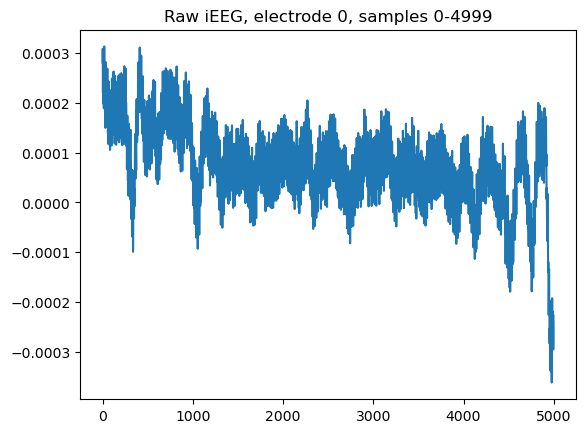

In [9]:
# Sanity check one channel data
plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Examine photodiode

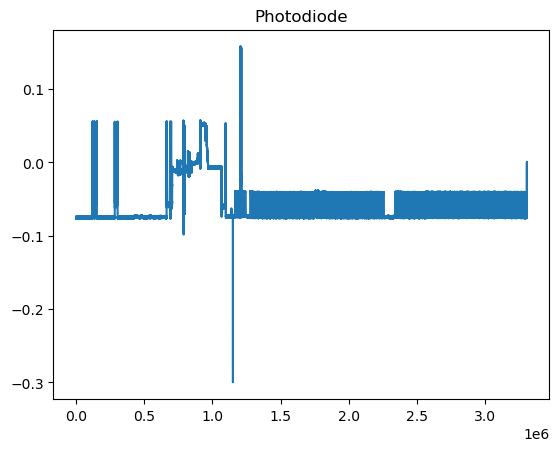

In [10]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("DC1")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

### Import Anat Recon Info - check all elecs are present in data + recon sheet


### Fix edf channel names

In [11]:
# Load the electrode localization data
ms020_anat_file = glob(f'{anat_dir}/MS020_labels.csv')[0]
elec_locs = pd.read_csv(ms020_anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,Manual Examination,Notes
0,LaCaS1,A32sg_L,-4.345531,38.931609,2.348619,-4.366555,31.312979,-9.076791,Gray,Left ACgG anterior cingulate gyrus,Area s24,L ACC,L CG,Left cingulate gyrus D,NaN,NaN
1,LaCaS10,A9l_L,-13.125783,44.927898,45.904190,-15.823208,44.034192,42.094287,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 2 C,NaN,NaN
2,LaCaS11,A9l_L,-13.923987,45.327651,50.699299,-16.731668,45.244361,47.722366,Gray,Left SFG superior frontal gyrus,Unknown,L Superior Frontal Gyrus,L SFG,Left superior frontal gyrus 3 D,OOB,borderline
3,LaCaS12,Unknown,-15.121294,46.127156,56.293593,-18.020168,46.918970,54.080927,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32sg_L,-5.542839,39.731114,7.143727,-5.882562,33.113344,-3.397774,Gray,Left ACgG anterior cingulate gyrus,Area 33,L ACC,L CG,Left cingulate gyrus D,WM,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,RmOlF9,IFS_R,40.753032,44.927898,15.135575,47.286859,40.810345,5.732863,Gray,Right TrIFG triangular part of the inferior fr...,Unknown,R IFG (p Triangularis),R IFG,Right anterior pars triangularis A,WM,NaN
140,uLAgIT,A38m_L,-22.704239,20.942741,-16.831817,-23.780532,7.255775,-28.784219,Gray,Left TMP temporal pole,Unknown,L Temporal Pole,L STG,Left superior temporal pole A,Left parahippocampal gyrus A,NaN
141,uLmOlF,A11m_L,-5.941941,42.929135,-9.639154,-5.742138,33.076356,-24.452764,Gray,Left GRe gyrus rectus,Area Fo1,L Rectal Gyrus,L OrG,Left frontal orbital 4 A,NaN,NaN
142,uRAgIT,rHipp_R,14.013176,10.948926,-17.631001,17.531295,-3.865333,-26.684077,Gray,Right PHG parahippocampal gyrus,Entorhinal Cortex,R ParaHippocampal Gyrus,R Hipp,Right parahippocampal gyrus A,NaN,NaN


In [12]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAgIT1',
 'LAgIT2',
 'LAgIT3',
 'LAgIT4',
 'LAgIT5',
 'LAgIT6',
 'LAgIT7',
 'LAgIT8',
 'LAgIT9',
 'LaLIT1',
 'LaLIT2',
 'LaLIT3',
 'LaLIT4',
 'LaLIT5',
 'LaLIT6',
 'LaLIT7',
 'LaLIT8',
 'LaLmF1',
 'LaLmF10',
 'LaLmF11',
 'LaLmF12',
 'LaLmF13',
 'LaLmF14',
 'LaLmF2',
 'LaLmF3',
 'LaLmF4',
 'LaLmF5',
 'LaLmF6',
 'LaLmF7',
 'LaLmF8',
 'LaLmF9',
 'RHpIT1',
 'RHpIT10',
 'RHpIT2',
 'RHpIT3',
 'RHpIT4',
 'RHpIT5',
 'RHpIT6',
 'RHpIT7',
 'RHpIT8',
 'RHpIT9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'RaCaS1',
 'RaCaS10',
 'RaCaS11',
 'RaCaS12',
 'RaCaS13',
 'RaCaS14',
 'RaCaS2',
 'RaCaS3',
 'RaCaS4',
 'RaCaS5',
 'RaCaS6',
 'RaCaS7',
 'RaCaS8',
 'RaCaS9',
 'RAgIT1',
 'RAgIT2',
 'RAgIT3',
 'RAgI

In [13]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


In [14]:
unmatched_names

['urmolf', 'uragit', 'ulmolf', 'ulagit']

In [15]:
unmatched_seeg  #make sure there are no unmatched names

[]

In [16]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [17]:
new_name_dict

{'LmOIF1': 'lmolf1',
 'LmOIF2': 'lmolf2',
 'LmOIF3': 'lmolf3',
 'LmOIF4': 'lmolf4',
 'LmOIF5': 'lmolf5',
 'LmOIF6': 'lmolf6',
 'LmOIF7': 'lmolf7',
 'LmOIF8': 'lmolf8',
 'LmOIF9': 'lmolf9',
 'RmOIF1': 'rmolf1',
 'RmOIF2': 'rmolf2',
 'RmOIF3': 'rmolf3',
 'RmOIF4': 'rmolf4',
 'RmOIF5': 'rmolf5',
 'RmOIF6': 'rmolf6',
 'RmOIF7': 'rmolf7',
 'RmOIF8': 'rmolf8',
 'RmOIF9': 'rmolf9',
 'LaCaS1': 'lacas1',
 'LaCaS2': 'lacas2',
 'LaCaS3': 'lacas3',
 'LaCaS4': 'lacas4',
 'LaCaS5': 'lacas5',
 'LaCaS6': 'lacas6',
 'LaCaS7': 'lacas7',
 'LaCaS8': 'lacas8',
 'LaCaS9': 'lacas9',
 'LaCaS10': 'lacas10',
 'LaCaS11': 'lacas11',
 'LaCaS12': 'lacas12',
 'RaCaS1': 'racas1',
 'RaCaS2': 'racas2',
 'RaCaS3': 'racas3',
 'RaCaS4': 'racas4',
 'RaCaS5': 'racas5',
 'RaCaS6': 'racas6',
 'RaCaS7': 'racas7',
 'RaCaS8': 'racas8',
 'RaCaS9': 'racas9',
 'RaCaS10': 'racas10',
 'RaCaS11': 'racas11',
 'RaCaS12': 'racas12',
 'RaCaS13': 'racas13',
 'RaCaS14': 'racas14',
 'LmCmS1': 'lmcms1',
 'LmCmS2': 'lmcms2',
 'LmCmS3': 'lmcms3

In [18]:
# Rename the mne data according to the localization data
mne_data.rename_channels(new_name_dict)

<RawEDF | MS020_SWB.edf, 276 x 3306048 (3228.6 s), ~6.80 GB, data loaded>

In [19]:
unmatched_seeg

[]

In [20]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['c125', 'c126', 'c127', 'c128', 'fp1', 'f7', 't3', 't5', 'o1', 'f3', 'c3', 'p3', 'fp2', 'f8', 't4', 't6', 'o2', 'f4', 'c4', 'p4', 'fz', 'cz', 'pz', 'ekg1', 'ekg2', 'c166', 'c167', 'c168', 'c169', 'c170', 'c171', 'c172', 'c173', 'c174', 'c175', 'c176', 'c177', 'c178', 'c179', 'c180', 'c181', 'c182', 'c183', 'c184', 'c185', 'c186', 'c187', 'c188', 'c189', 'c190', 'c191', 'c192', 'c193', 'c194', 'c195', 'c196', 'c197', 'c198', 'c199', 'c200', 'c201', 'c202', 'c203', 'c204', 'c205', 'c206', 'c207', 'c208', 'c209', 'c210', 'c211', 'c212', 'c213', 'c214', 'c215', 'c216', 'c217', 'c218', 'c219', 'c220', 'c221', 'c222', 'c223', 'c224', 'c225', 'c226', 'c227', 'c228', 'c229', 'c230', 'c231', 'c232', 'c233', 'c234', 'c235', 'c236', 'c237', 'c238', 'c239', 'c240', 'c241', 'c242', 'c243', 'c244', 'c245', 'c246', 'c247', 'c248', 'c249', 'c250', 'c251', 'c252', 'c253', 'c254', 'c255', 'c256', 'dc1', 'dc2', 'dc3', 'dc4', 'dc5', 'dc6', 'dc7', 'dc8', 'dc9', 'dc10', 'dc11', 'dc12', 'dc13', 'dc14', 'dc1

In [21]:
# Note, there is surface EEG data that we should separately indicate from the sEEG:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of', len(left_seeg_names), 'left &', len(right_seeg_names), 'right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')


We have a total of 72 left & 68 right sEEG electrodes
We have a total of 140 sEEG electrodes


In [22]:
list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1'])) #list of non seeg/photodiode channels

['o2',
 'c227',
 'c176',
 'c4',
 'c242',
 'c128',
 'dc2',
 'dc4',
 'c168',
 'pz',
 'c189',
 'c228',
 'c198',
 'c214',
 'o1',
 'ekg1',
 'c230',
 'c177',
 'c229',
 't6',
 'c179',
 'c238',
 'fp1',
 'c180',
 'c201',
 'c196',
 'c254',
 'c205',
 'c248',
 'c197',
 'c186',
 'c178',
 'c194',
 'c249',
 'dc10',
 'c174',
 'c183',
 'c253',
 'p3',
 'c173',
 'pleth',
 't3',
 'c246',
 'dc8',
 'c237',
 'c187',
 'c184',
 'dc11',
 'dc6',
 'pr',
 'f3',
 'c167',
 'c171',
 'dc13',
 'c199',
 't5',
 'c223',
 'c212',
 'c232',
 'c204',
 't4',
 'c172',
 'c191',
 'cz',
 'c209',
 'c251',
 'c240',
 'c224',
 'c217',
 'c126',
 'c182',
 'c206',
 'f8',
 'c3',
 'c231',
 'c192',
 'p4',
 'dc14',
 'c235',
 'dc9',
 'c190',
 'dc12',
 'c239',
 'c236',
 'c200',
 'dc7',
 'c213',
 'c195',
 'c219',
 'c127',
 'c175',
 'ekg2',
 'dc5',
 'c193',
 'c215',
 'f7',
 'c241',
 'c244',
 'fp2',
 'c169',
 'dc15',
 'c210',
 'c250',
 'c181',
 'trig',
 'c255',
 'c243',
 'fz',
 'c225',
 'dc16',
 'c220',
 'c208',
 'c247',
 'c222',
 'c185',
 'c211'

In [23]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names+['dc1']))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs + 1 (photodiode)

<RawEDF | MS020_SWB.edf, 141 x 3306048 (3228.6 s), ~3.47 GB, data loaded>

In [25]:
# Set channel types:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
trig_mapping_dict = {'dc1':'stim'} #stim stands for stimulus
mne_data.set_channel_types(sEEG_mapping_dict)
mne_data.set_channel_types(trig_mapping_dict)

<RawEDF | MS020_SWB.edf, 141 x 3306048 (3228.6 s), ~3.47 GB, data loaded>

In [26]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawEDF | MS020_SWB.edf, 141 x 3306048 (3228.6 s), ~3.47 GB, data loaded>

### Notch filter line noise

In [27]:
# Identify line noise
mne_data.info['line_freq'] = 60

# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:   11.4s finished


<RawEDF | MS020_SWB.edf, 141 x 3306048 (3228.6 s), ~3.47 GB, data loaded>

### Resampling Data

In [28]:
#resampling if patient is not sampled at 512
resample_sr = 512
mne_data.resample(sfreq=resample_sr, npad='auto', n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 141 out of 141 | elapsed:   14.3s finished


<RawEDF | MS020_SWB.edf, 141 x 1653024 (3228.6 s), ~1.74 GB, data loaded>

### Save out photodiode data
Note: this is after filtering out line noise and resampling

In [29]:
mne_data.save(f'{neural_dir}/MS020/photodiode.fif', picks='dc1', overwrite=True)

### Detect bad channels - detect_bad_elecs function auto detects, then we validate manually 

In [30]:
#make_mne function auto-detects bad electrodes. I want to compare auto vs manual ictal detection

bads = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #worked perfectly for this pt besides photodiode
mne_data.info['bads'] = bads

In [32]:
bads #bads picked up research? - manually remove
#bads = bads[:-1]
#bads

['lagit4',
 'lagit5',
 'lagit7',
 'lalmf4',
 'lmcms7',
 'lmolf5',
 'lmolf6',
 'lmolf7',
 'lmolf8',
 'lmolf9',
 'racas13',
 'ragit5',
 'ralmf1',
 'rhpit8']

In [33]:
mne_data.info['bads'] = bads

In [34]:
mne_data.info

<Info | 10 non-empty values
 bads: 14 items (lagit4, lagit5, lagit7, lalmf4, lmcms7, lmolf5, ...)
 ch_names: lmolf1, lmolf2, lmolf3, lmolf4, lmolf5, lmolf6, lmolf7, lmolf8, ...
 chs: 140 sEEG
 custom_ref_applied: False
 dig: 140 items (140 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 13:08:46 UTC
 nchan: 140
 projs: []
 sfreq: 512.0 Hz
>

In [35]:
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)

In [36]:
probe_names

array(['lacas', 'lagit', 'lalit', 'lalmf', 'lhpit', 'lmcms', 'lmolf',
       'racas', 'ragit', 'ralmf', 'rhpit', 'rmcms', 'rmolf', 'ulagit',
       'ulmolf', 'uragit', 'urmolf'], dtype='<U6')

In [37]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [38]:
probe_ch_counts

{'lacas': 12,
 'lagit': 9,
 'lalit': 8,
 'lalmf': 14,
 'lhpit': 10,
 'lmcms': 10,
 'lmolf': 9,
 'racas': 14,
 'ragit': 9,
 'ralmf': 16,
 'rhpit': 10,
 'rmcms': 10,
 'rmolf': 9,
 'ulagit': 1,
 'ulmolf': 1,
 'uragit': 1,
 'urmolf': 1}

<IPython.core.display.Javascript object>


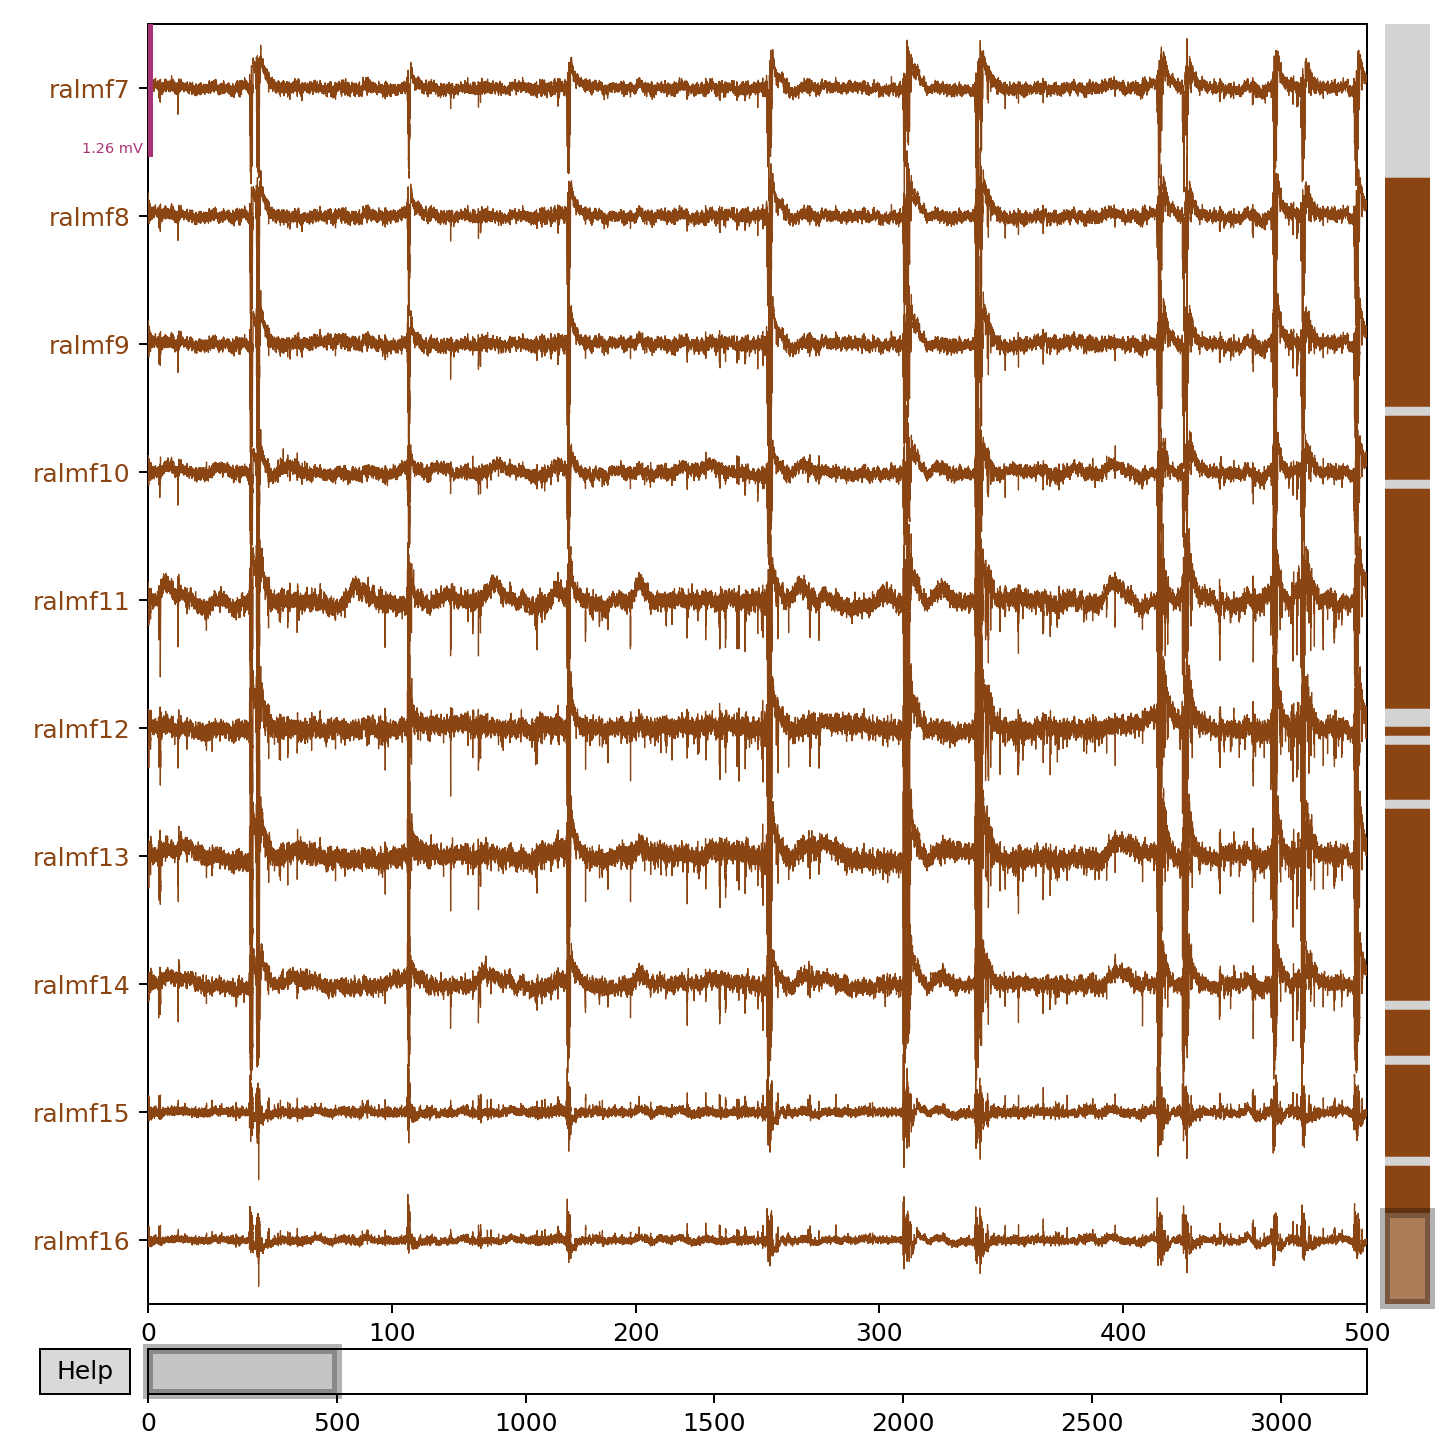

<IPython.core.display.Javascript object>


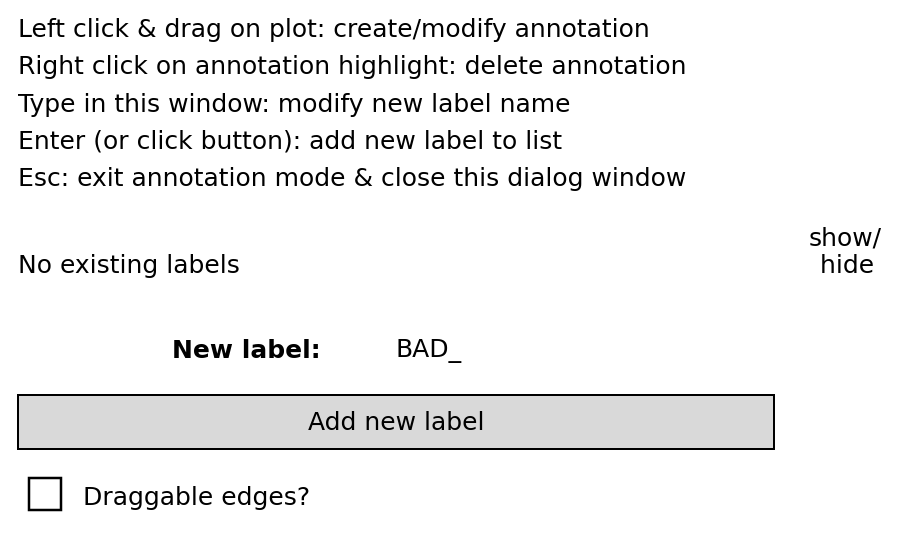

In [39]:
%matplotlib notebook 
fig = mne_data.plot(start=0, duration=500, n_channels=10, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [42]:
mne_data.info['bads']

['lpioc14',
 'lpioc2',
 'lpioc3',
 'riito5',
 'riito6',
 'riito7',
 'rmoif1',
 'rsppc5',
 'rsppc7',
 'rsppc8']

<IPython.core.display.Javascript object>


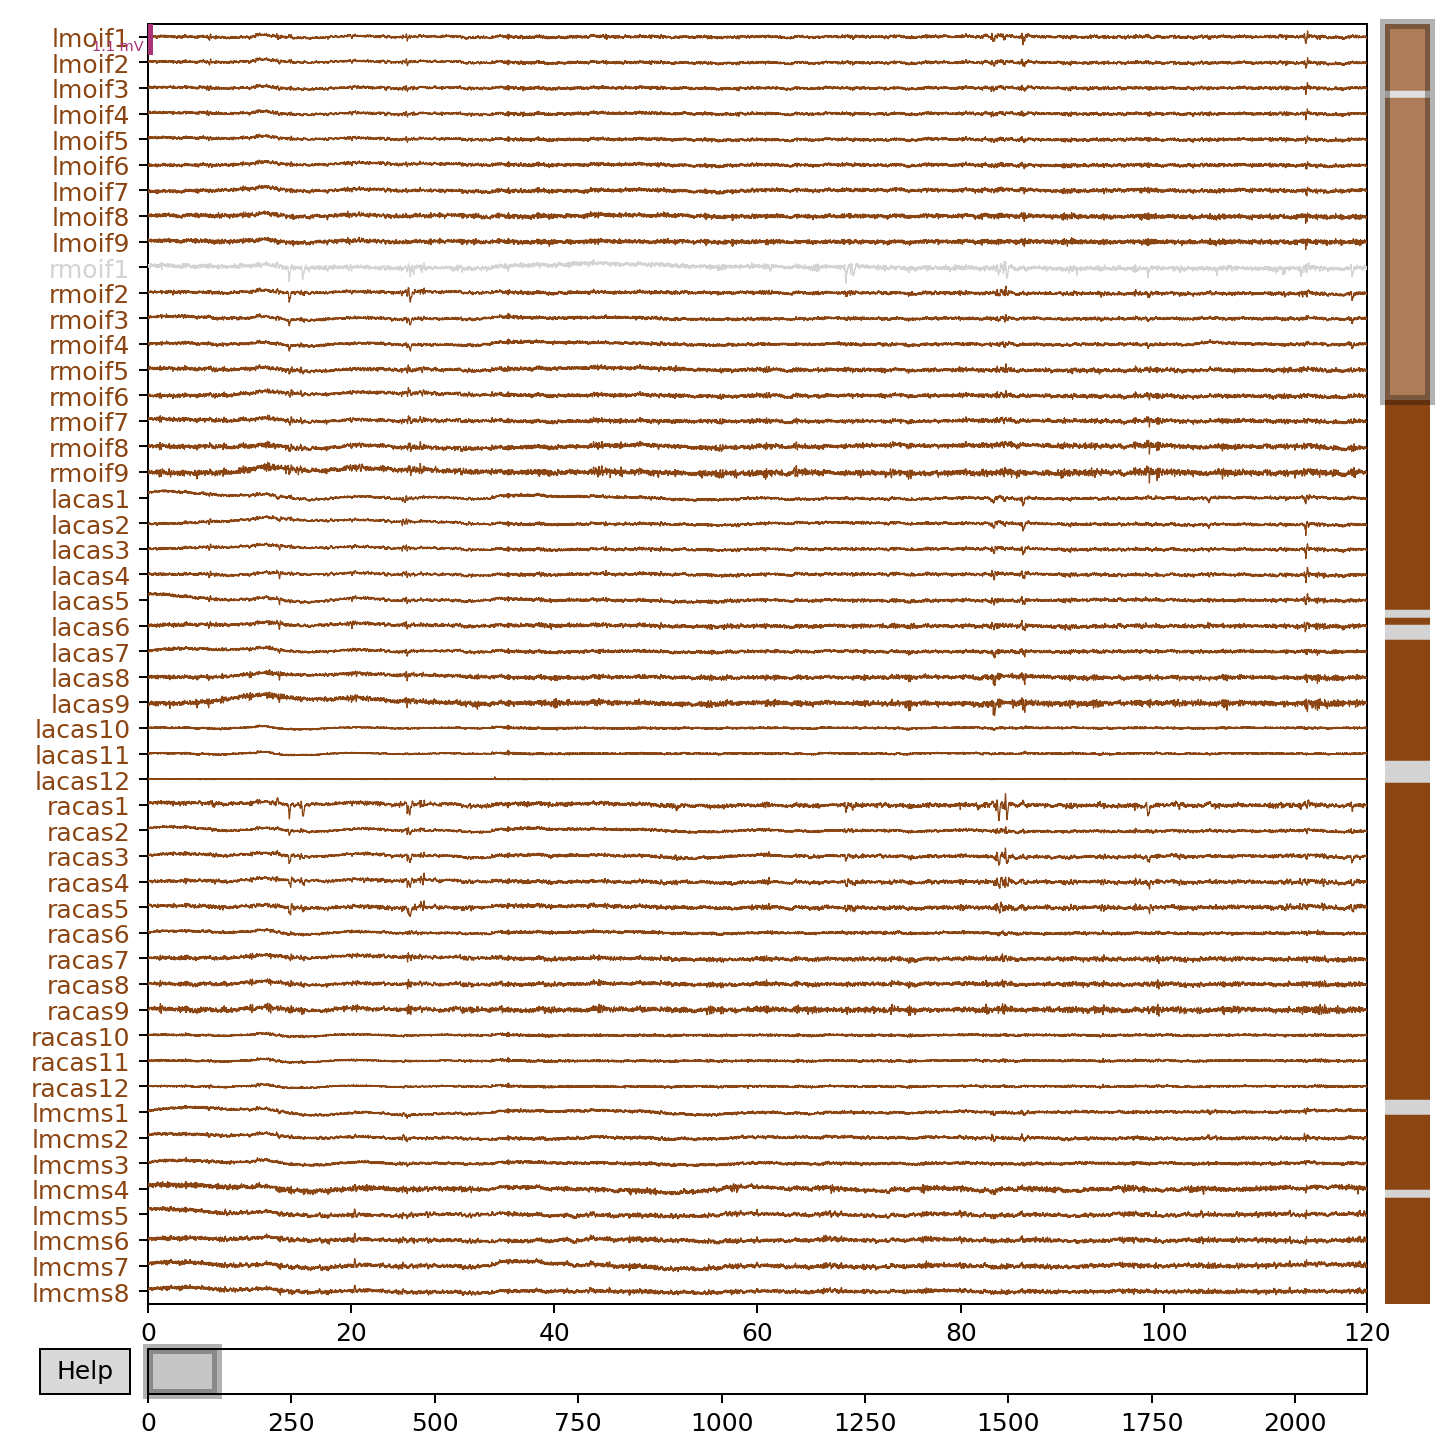

<IPython.core.display.Javascript object>


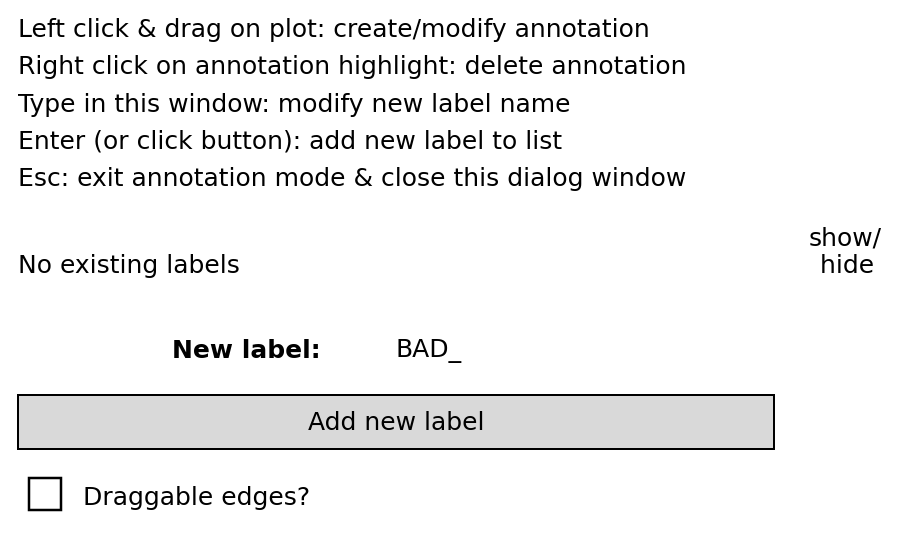

In [53]:
%matplotlib notebook
fig = mne_data.plot(start=0, duration=120, n_channels=50, scalings=mne_data._data.max()/20)
fig.fake_keypress('a')

In [46]:
mne_data.info['bads'] 

['lpioc14',
 'lpioc2',
 'lpioc3',
 'riito5',
 'riito6',
 'riito7',
 'rmoif1',
 'rsppc5',
 'rsppc7',
 'rsppc8']

In [47]:
#set bad channel info 
ms020_bad_ch = ['lagit4','lagit5','lagit7','lalmf4','lmcms7','lmolf5','lmolf6','lmolf7','lmolf8','lmolf9','racas13','ragit5','ralmf1','rhpit8']


In [49]:
len(ms019_bad_ch)

4

In [54]:
#manually set bads because doing it in the plot is too buggy
mne_data.info['bads'] = ms019_bad_ch 

In [55]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 4 items (ragit9, lsppc11, lsppc12, rsppc12)
 ch_names: lmoif1, lmoif2, lmoif3, lmoif4, lmoif5, lmoif6, lmoif7, lmoif8, ...
 chs: 170 sEEG
 custom_ref_applied: False
 dig: 170 items (170 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 256.0 Hz
 meas_date: 2001-01-01 10:46:21 UTC
 nchan: 170
 projs: []
 sfreq: 512.0 Hz
>

In [56]:
mne_data.info['bads'] #more sanity checking

['ragit9', 'lsppc11', 'lsppc12', 'rsppc12']

### Rereference data to wm electrodes

In [57]:
anode_list, cathode_list, drop_wm_channels, oob_channels = lfp_preprocess_utils.wm_ref(mne_data=mne_data, 
                                                                                elec_path=ms019_anat_file, 
                                                                                unmatched_seeg = unmatched_seeg,
                                                                                bad_channels=mne_data.info['bads'],
                                                                                      site = 'MSSM')

In [58]:
oob_channels

['lacas11',
 'lacas12',
 'lhpit10',
 'liito2',
 'liito7',
 'liito8',
 'lmcms10',
 'lmcms8',
 'lmcms9',
 'lsppc11',
 'lsppc12',
 'racas11',
 'racas12',
 'ragit10',
 'rhpit10',
 'riito7',
 'riito8',
 'rmcms10',
 'rmcms8',
 'rmcms9',
 'rpioc14',
 'rsppc11',
 'rsppc12']

In [59]:
#need to distinguish between wm channels and oob channels 

#add oob channels to bad channels list
ms019_bad_ch = ms019_bad_ch + oob_channels
ms019_bad_ch = list(np.unique(ms019_bad_ch))
mne_data.info['bads'] = ms019_bad_ch

In [62]:
mne_data.info['bads'] #needed to rerun plotting function to find this again?

['lacas11',
 'lacas12',
 'lhpit10',
 'liito2',
 'liito7',
 'liito8',
 'lmcms10',
 'lmcms8',
 'lmcms9',
 'lsppc11',
 'lsppc12',
 'racas11',
 'racas12',
 'ragit10',
 'ragit9',
 'rhpit10',
 'riito7',
 'riito8',
 'rmcms10',
 'rmcms8',
 'rmcms9',
 'rpioc14',
 'rsppc11',
 'rsppc12']

In [63]:
mne_data_reref = mne.set_bipolar_reference(mne_data, 
                      anode=anode_list, 
                      cathode=cathode_list,
                      copy=True)

In [64]:
mne_data_reref

<RawEDF | MS019_SWB.edf, 138 x 1088000 (2125.0 s), ~1.12 GB, data loaded>

### Save cleaned continuous data

In [74]:
mne_data.save(f'{neural_dir}/MS019/lfp_data.fif',overwrite=True)

In [65]:
mne_data_reref.save(f'{neural_dir}/MS019/wm_ref_ieeg.fif',overwrite=True)